In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/NLP

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/NLP


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pandas as pd
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import v_measure_score
from sklearn.cluster import KMeans, DBSCAN
import numpy as np
from torch.utils.data import TensorDataset
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
  device = torch.device('cpu')

In [ ]:
data = pd.read_csv("bibledata.csv")

In [ ]:
means = torch.load("bible_similar_mean.pt", map_location = device)
embeddings = torch.load("bible_embeddings.pt", map_location = device)

styles = embeddings - means
target = F.normalize(styles)

In [ ]:
similarity_matrix = embeddings.matmul(embeddings.T)

In [ ]:
top_n = similarity_matrix.sort()[1][:,-7:-1]

In [ ]:
random.seed(42)
dataset = TensorDataset(embeddings, target, torch.arange(len(data)).to(device))
train_dataloader = DataLoader(dataset, batch_size=73, shuffle=True, drop_last = True)

In [ ]:
l1 = 256
l2 = 128
z_dim = 64

In [ ]:
class L2Norm(nn.Module):
    def __init__(self, dim=1, eps=1e-12):
        super(L2Norm, self).__init__()
        self.dim = dim
        self.eps = eps

    def forward(self, x):
        self.dim = len(x.shape) - 1
        return F.normalize(x, p=2, dim=self.dim, eps=self.eps)

In [ ]:
def Encoder(x_dim, z_dim):
  model = nn.Sequential(
    nn.Linear(x_dim, l1),
    nn.ReLU(),
    nn.Linear(l1, l2),
    nn.ReLU(),
    nn.Linear(l2, z_dim))
  return model

In [ ]:
def Decoder(x_dim, z_dim):
  model = nn.Sequential(
    nn.Linear(z_dim, l2),
    nn.ReLU(),
    nn.Linear(l2, l1),
    nn.ReLU(),
    nn.Linear(l1, x_dim),
    L2Norm())
  return model

In [ ]:
class Model(nn.Module):
  def __init__(self, x_dim, z_dim, eps = 0.005):
      super(Model, self).__init__()
      self.Encoder = Encoder(x_dim, z_dim)
      self.Decoder = Decoder(x_dim, z_dim)
      self.eps = eps

  def perturb(self, x, eps=None):
      if eps is None:
        eps = self.eps
      return x + eps*torch.randn(x.shape).to(device)

  def forward(self, x):
      x = self.perturb(x)
      z = self.Encoder(x)
      out = self.Decoder(z)
        
      return out

In [ ]:
epochs = 50
batch_size = 73

In [ ]:
model = Model(384, z_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
for epoch in tqdm(range(epochs)):
    overall_loss = 0
    for batch_idx, (x, label, index) in enumerate(train_dataloader):
        x = x.view(batch_size, 384)
        nearest = embeddings[top_n[index]]

        optimizer.zero_grad()
        predict = model(x)
        nears = model.Encoder(nearest)

        loss = 0
        loss += 1*torch.sum(torch.square(1 - F.cosine_similarity(predict, label)))
        loss += 1*torch.sum(torch.square(1 - F.cosine_similarity(model.Encoder(x), model.Encoder(model.perturb(x, model.eps*10)))))
        loss += 1/6*torch.sum(torch.square(F.cosine_similarity(model.Encoder(x).unsqueeze(1), nears, dim=2)))
      
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))

  2%|▏         | 1/50 [00:01<01:17,  1.59s/it]

	Epoch 1 complete! 	Average Loss:  0.5713692581168168


  4%|▍         | 2/50 [00:02<00:56,  1.19s/it]

	Epoch 2 complete! 	Average Loss:  0.4547294787426428


  6%|▌         | 3/50 [00:03<00:48,  1.03s/it]

	Epoch 3 complete! 	Average Loss:  0.4140506428700492


  8%|▊         | 4/50 [00:04<00:44,  1.03it/s]

	Epoch 4 complete! 	Average Loss:  0.387278858728135


 10%|█         | 5/50 [00:05<00:41,  1.07it/s]

	Epoch 5 complete! 	Average Loss:  0.369691274116446


 12%|█▏        | 6/50 [00:05<00:39,  1.11it/s]

	Epoch 6 complete! 	Average Loss:  0.3536878323818958


 14%|█▍        | 7/50 [00:06<00:37,  1.13it/s]

	Epoch 7 complete! 	Average Loss:  0.3449732019342475


 16%|█▌        | 8/50 [00:07<00:38,  1.09it/s]

	Epoch 8 complete! 	Average Loss:  0.33131244621484446


 18%|█▊        | 9/50 [00:08<00:41,  1.00s/it]

	Epoch 9 complete! 	Average Loss:  0.3243523737484529


 20%|██        | 10/50 [00:10<00:42,  1.05s/it]

	Epoch 10 complete! 	Average Loss:  0.31788275831970225


 22%|██▏       | 11/50 [00:11<00:41,  1.06s/it]

	Epoch 11 complete! 	Average Loss:  0.3096839176778566


 24%|██▍       | 12/50 [00:12<00:37,  1.00it/s]

	Epoch 12 complete! 	Average Loss:  0.30523639764139726


 26%|██▌       | 13/50 [00:12<00:35,  1.04it/s]

	Epoch 13 complete! 	Average Loss:  0.2988153115113427


 28%|██▊       | 14/50 [00:13<00:33,  1.08it/s]

	Epoch 14 complete! 	Average Loss:  0.29732964655811195


 30%|███       | 15/50 [00:14<00:31,  1.10it/s]

	Epoch 15 complete! 	Average Loss:  0.29043078122789495


 32%|███▏      | 16/50 [00:15<00:30,  1.11it/s]

	Epoch 16 complete! 	Average Loss:  0.28552352699828115


 34%|███▍      | 17/50 [00:16<00:29,  1.13it/s]

	Epoch 17 complete! 	Average Loss:  0.28434187969093944


 36%|███▌      | 18/50 [00:17<00:27,  1.15it/s]

	Epoch 18 complete! 	Average Loss:  0.28095952680218755


 38%|███▊      | 19/50 [00:18<00:26,  1.16it/s]

	Epoch 19 complete! 	Average Loss:  0.27824964843652644


 40%|████      | 20/50 [00:18<00:26,  1.15it/s]

	Epoch 20 complete! 	Average Loss:  0.2711708233848167


 42%|████▏     | 21/50 [00:19<00:25,  1.16it/s]

	Epoch 21 complete! 	Average Loss:  0.2707821066998299


 44%|████▍     | 22/50 [00:20<00:24,  1.16it/s]

	Epoch 22 complete! 	Average Loss:  0.26861956392897746


 46%|████▌     | 23/50 [00:21<00:25,  1.06it/s]

	Epoch 23 complete! 	Average Loss:  0.26502812693906025


 48%|████▊     | 24/50 [00:23<00:26,  1.03s/it]

	Epoch 24 complete! 	Average Loss:  0.2628738999612829


 50%|█████     | 25/50 [00:24<00:27,  1.08s/it]

	Epoch 25 complete! 	Average Loss:  0.2599280494801612


 52%|█████▏    | 26/50 [00:25<00:24,  1.04s/it]

	Epoch 26 complete! 	Average Loss:  0.25701976900678747


 54%|█████▍    | 27/50 [00:26<00:22,  1.01it/s]

	Epoch 27 complete! 	Average Loss:  0.2544493257361877


 56%|█████▌    | 28/50 [00:26<00:20,  1.05it/s]

	Epoch 28 complete! 	Average Loss:  0.2520878530170529


 58%|█████▊    | 29/50 [00:27<00:19,  1.08it/s]

	Epoch 29 complete! 	Average Loss:  0.2535464167259361


 60%|██████    | 30/50 [00:28<00:18,  1.11it/s]

	Epoch 30 complete! 	Average Loss:  0.25089836505368046


 62%|██████▏   | 31/50 [00:29<00:16,  1.13it/s]

	Epoch 31 complete! 	Average Loss:  0.24824351587937996


 64%|██████▍   | 32/50 [00:30<00:15,  1.15it/s]

	Epoch 32 complete! 	Average Loss:  0.24743130981508307


 66%|██████▌   | 33/50 [00:31<00:14,  1.16it/s]

	Epoch 33 complete! 	Average Loss:  0.24273974265987822


 68%|██████▊   | 34/50 [00:31<00:13,  1.16it/s]

	Epoch 34 complete! 	Average Loss:  0.24262014010718044


 70%|███████   | 35/50 [00:32<00:12,  1.16it/s]

	Epoch 35 complete! 	Average Loss:  0.24046763337604726


 72%|███████▏  | 36/50 [00:33<00:12,  1.16it/s]

	Epoch 36 complete! 	Average Loss:  0.2403352953609639


 74%|███████▍  | 37/50 [00:34<00:11,  1.11it/s]

	Epoch 37 complete! 	Average Loss:  0.23915968381524152


 76%|███████▌  | 38/50 [00:35<00:12,  1.01s/it]

	Epoch 38 complete! 	Average Loss:  0.2385384934909081


 78%|███████▊  | 39/50 [00:37<00:11,  1.06s/it]

	Epoch 39 complete! 	Average Loss:  0.2380779237366009


 80%|████████  | 40/50 [00:38<00:10,  1.06s/it]

	Epoch 40 complete! 	Average Loss:  0.23643290103991813


 82%|████████▏ | 41/50 [00:39<00:08,  1.01it/s]

	Epoch 41 complete! 	Average Loss:  0.23484069183902237


 84%|████████▍ | 42/50 [00:39<00:07,  1.05it/s]

	Epoch 42 complete! 	Average Loss:  0.23683206277619295


 86%|████████▌ | 43/50 [00:40<00:06,  1.09it/s]

	Epoch 43 complete! 	Average Loss:  0.23410845617121437


 88%|████████▊ | 44/50 [00:41<00:05,  1.10it/s]

	Epoch 44 complete! 	Average Loss:  0.2322995903836918


 90%|█████████ | 45/50 [00:42<00:04,  1.12it/s]

	Epoch 45 complete! 	Average Loss:  0.23224140953941583


 92%|█████████▏| 46/50 [00:43<00:03,  1.13it/s]

	Epoch 46 complete! 	Average Loss:  0.23124481379415376


 94%|█████████▍| 47/50 [00:44<00:02,  1.14it/s]

	Epoch 47 complete! 	Average Loss:  0.22903431663148108


 96%|█████████▌| 48/50 [00:45<00:01,  1.13it/s]

	Epoch 48 complete! 	Average Loss:  0.23028981347852676


 98%|█████████▊| 49/50 [00:45<00:00,  1.14it/s]

	Epoch 49 complete! 	Average Loss:  0.22851662430894779


100%|██████████| 50/50 [00:46<00:00,  1.07it/s]

	Epoch 50 complete! 	Average Loss:  0.2290127364616945


In [ ]:
zs = model.Encoder(embeddings).detach().cpu()
km = KMeans(n_clusters = 7)
km.fit(zs)
data["labels"] = km.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
v_measure_score(data.id, data.labels)

0.3102070648622784

In [ ]:
km.fit(styles.cpu().detach())
data["ll"] = km.labels_
v_measure_score(data.id, data.ll)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.31766821631268227

In [ ]:
#torch.save(model.state_dict(), "401.pt")

In [ ]:
x = data.pivot_table(index = 'id', columns = 'labels', values = 'text', aggfunc = "count").fillna(0).astype(int)
y = data.pivot_table(index = 'id', columns = 'll', values = 'text', aggfunc = "count").fillna(0).astype(int)

In [ ]:
print((x.max() / x.sum()).mean())
print(x.max().sum()/x.sum().sum())

0.7263908084005216
0.46454198117603207


In [ ]:
print((y.max() / y.sum()).mean())
print(y.max().sum()/y.sum().sum())

0.5263365663193208
0.41748206131767773


<Axes: xlabel='labels', ylabel='id'>

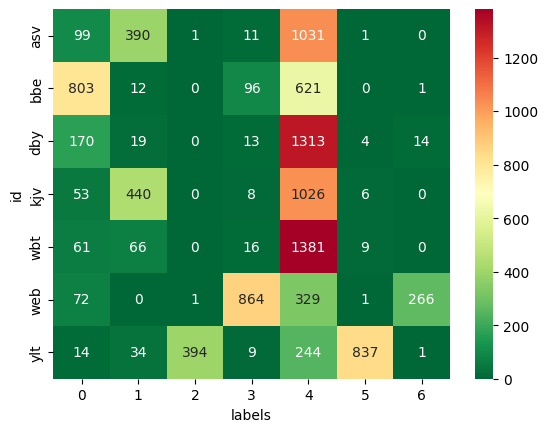

In [ ]:
sns.heatmap(x, annot = True, fmt = 'd', cmap='RdYlGn_r')
#plt.savefig('heatmap.png')

<Axes: xlabel='ll', ylabel='id'>

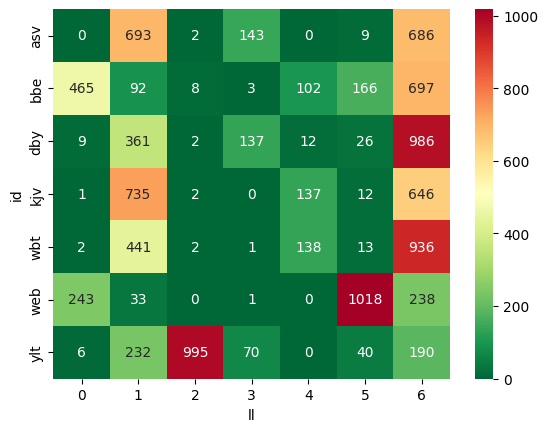

In [ ]:
sns.heatmap(y, annot = True, fmt = 'd', cmap='RdYlGn_r')
#plt.savefig('l_heatmap.png')